In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
import xgboost as xgb

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
data_dict = pd.read_csv('../data/data_dictionary.csv')

In [3]:
train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [31]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

pciat = train.columns[train.columns.str.startswith('PCIAT-PCIAT')].tolist() + ['sii', "PCIAT-Season"]

In [32]:
train_clean = pd.concat([train, pd.get_dummies(train[cat_c]).astype(int)], axis=1)

to_drop = ["id"] + cat_c
train_clean = train_clean.drop(to_drop, axis=1)

train_clean = train_clean.dropna(subset=pciat)

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_clean.drop(pciat, axis=1), train_clean['sii'], test_size=0.2, random_state=42)

In [50]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier

# Initialize the model
first_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1)

# Fit the model
first_model.fit(x_train.to_numpy(), y_train.to_numpy())

# Predict on the test set
y_pred = first_model.predict(x_test.to_numpy())

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for xgb alone: {accuracy}")
# Initialize the models
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, verbose=0)
lightgbm_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1)

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', first_model),
    ('catboost', catboost_model),
    ('lightgbm', lightgbm_model)
], voting='soft')

# Fit the voting classifier
voting_clf.fit(x_train, y_train)

# Predict on the test set
y_pred_voting = voting_clf.predict(x_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy_voting}")

Accuracy for xgb alone: 0.6093457943925233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5936
[LightGBM] [Info] Number of data points in the train set: 2136, number of used features: 88
[LightGBM] [Info] Start training from score -0.538194
[LightGBM] [Info] Start training from score -1.321054
[LightGBM] [Info] Start training from score -1.986518
[LightGBM] [Info] Start training from score -4.408594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [51]:
# quadratic weighted kappa

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b, min_rating, max_rating)
    num_scored_items = float(conf_mat.sum())
    num_ratings = float(len(conf_mat))
    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)
    numerator = 0.0
    denominator = 0.0
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat)):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(max_rating - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items
    return 1.0 - numerator / denominator

def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    num_ratings = max_rating - min_rating + 1
    conf_mat = [[0 for i in range(int(num_ratings))]
                for j in range(int(num_ratings))]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return np.array(conf_mat)

def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    hist_ratings = [0 for x in range(min_rating, max_rating + 1)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

In [52]:
print(f"Quadratic Weighted Kappa for xgb: {quadratic_weighted_kappa(y_test, y_pred)}")
print(f"Quadratic Weighted Kappa for Voting Classifier: {quadratic_weighted_kappa(y_test, y_pred_voting)}")

Quadratic Weighted Kappa for xgb: 0.3276956430420035
Quadratic Weighted Kappa for Voting Classifier: 0.3404486264812546


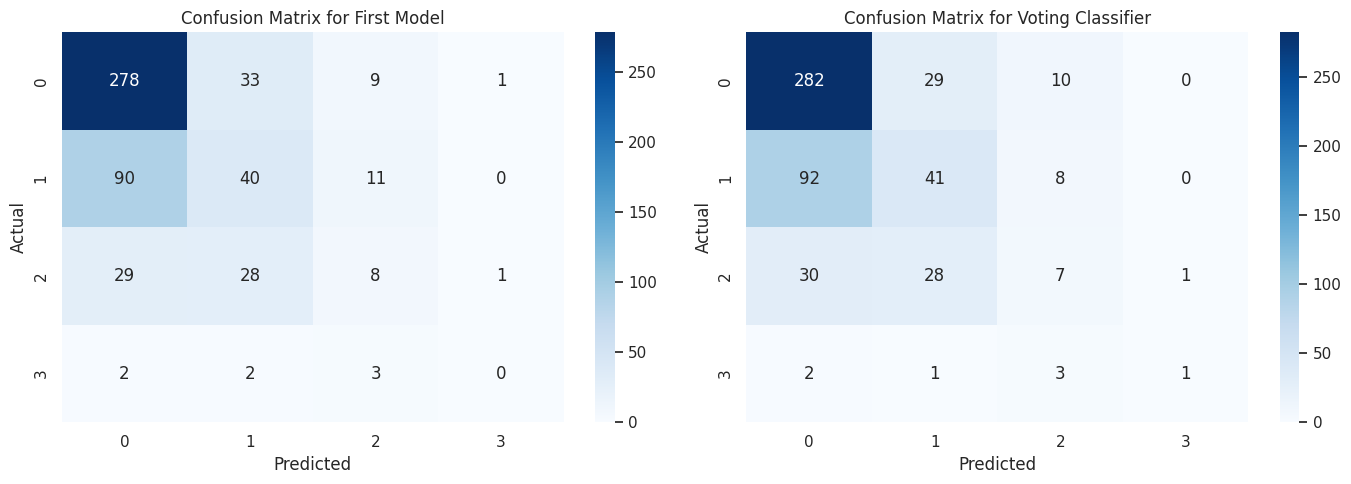

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrices
cm_first_model = confusion_matrix(y_test, y_pred)
cm_voting_clf = confusion_matrix(y_test, y_pred_voting)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_first_model, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for First Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_voting_clf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Voting Classifier')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()